In [1]:
import pandas as pd
import dask.dataframe as dd

# Read datasets
user_data = pd.read_csv("UserList.csv", engine = "python")
anime_data = pd.read_csv("AnimeList.csv", engine = "python")
useranime_data = dd.read_csv("UserAnimeList.csv", error_bad_lines = False)

# Data preprocessing: Model Data

In [2]:
model_data = useranime_data[["username", "anime_id", "my_watched_episodes", "my_score"]]

### Create Movie / TV watcher variable

In [59]:
watching_behavior = useranime_data.merge(anime_data, how = "left", left_on = "anime_id", right_on = "anime_id").head(1000000)

In [68]:
anime_type = pd.get_dummies(watching_behavior["type"])[["Movie", "TV"]]

In [70]:
watch_types = watching_behavior.merge(anime_type, how = "left", left_index = True, right_index = True)

In [75]:
watches = watch_types[["username", "Movie", "TV"]].groupby(by = "username").sum()

In [77]:
watches["movie_watcher"] = watches["Movie"] / watches["TV"]

## Data Preprocessing: Anime_Data

In [3]:
# View the different types and sources of manga

print(pd.unique(anime_data["type"]))
print(pd.unique(anime_data["source"]))

['TV' 'Movie' 'Music' 'OVA' 'ONA' 'Special' 'Unknown']
['Manga' 'Original' 'Light novel' '4-koma manga' 'Novel' 'Visual novel'
 'Unknown' 'Other' 'Music' 'Game' 'Picture book' 'Card game' 'Web manga'
 'Book' 'Radio' 'Digital manga']


In [4]:
# Filter by movie data and remove cases where a movie has episodes, to not corrupt the analysis

movie_data = anime_data[(anime_data["type"] == "Movie") & (anime_data["episodes"] <= 1)]

In [5]:
model_movie = movie_data[["anime_id", "source", "duration", "rating", "score", "scored_by", "rank", "popularity", "members", "favorites", "genre"]]

In [6]:
pd.unique(model_movie["duration"])

array(['Unknown', '1 hr. 36 min.', '25 min.', '49 min.', '8 min.',
       '4 min.', '45 min.', '14 min.', '50 min.', '43 min.',
       '1 hr. 40 min.', '20 min.', '1 min.', '46 min.', '1 hr. 20 min.',
       '41 min.', '17 min.', '1 hr. 29 min.', '1 hr.', '1 hr. 41 min.',
       '6 min.', '1 hr. 15 min.', '3 min.', '1 hr. 14 min.',
       '1 hr. 31 min.', '1 hr. 51 min.', '5 min.', '1 hr. 25 min.',
       '30 min.', '1 hr. 19 min.', '1 hr. 28 min.', '15 min.', '48 min.',
       '24 min.', '29 min.', '13 min.', '10 min.', '1 hr. 35 min.',
       '51 min.', '9 min.', '1 hr. 10 min.', '1 hr. 16 min.',
       '2 hr. 15 min.', '31 min.', '57 min.', '19 min.', '1 hr. 59 min.',
       '1 hr. 27 min.', '1 hr. 26 min.', '2 hr.', '1 hr. 45 min.',
       '1 hr. 30 min.', '1 hr. 34 min.', '1 hr. 17 min.', '1 hr. 12 min.',
       '21 min.', '12 min.', '1 hr. 39 min.', '23 min.', '1 hr. 38 min.',
       '1 hr. 4 min.', '27 min.', '44 min.', '1 hr. 33 min.',
       '1 hr. 48 min.', '2 hr. 11 min.', '

In [7]:
# Put duration in Minutes

import re

model_movie["duration_clean"] = model_movie["duration"].apply(lambda d: re.split("\W+", d))

def calculate_mins(time):
    
    duration = 0
    
    if len(time) <= 1:
        return duration
    
    elif len(time) <= 3:
        if time[1] == "hr":
            duration += (60 * float(time[0]))            
        if time[1] == "min":
            duration += float(time[0])
        if time[1] == "sec":
            duration += (float(time[0]) / 60)
    
    elif len(time) > 3:
            duration += (60 * float(time[0]))            
            duration += (float(time[2]))
            
    return duration

model_movie["mins"] = model_movie["duration_clean"].apply(lambda d: calculate_mins(d))

model_movie.head()

C:\Users\duart\AppData\Local\conda\conda\envs\testEnv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\duart\AppData\Local\conda\conda\envs\testEnv\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,anime_id,source,duration,rating,score,scored_by,rank,popularity,members,favorites,genre,duration_clean,mins
55,33185,Manga,Unknown,R - 17+ (violence & profanity),0.00,0,NaN,5215,4210,6,"Action, Comedy, Historical, Samurai, Shounen",[Unknown],0.0
77,35277,Other,1 hr. 36 min.,PG - Children,4.86,7,11408.0,13987,49,0,"Drama, Historical","[1, hr, 36, min, ]",96.0
78,14353,Original,25 min.,R - 17+ (violence & profanity),8.01,81162,542.0,637,132203,226,"Game, Mystery, Psychological, Drama, Thriller","[25, min, ]",25.0
81,8154,Unknown,49 min.,G - All Ages,6.17,60,6853.0,10204,342,0,"Adventure, Comedy, Fantasy, Horror, Supernatural","[49, min, ]",49.0
86,35594,Original,8 min.,None,5.86,7,12762.0,10399,313,0,"Action, Fantasy","[8, min, ]",8.0


### Encode dummy genre variables

In [8]:
# CLean genres variable

model_movie["genre"] = model_movie["genre"].apply(lambda d: str(d).replace(' ', ''))
model_movie["genre"] = model_movie["genre"].apply(lambda d: str(d).split(sep=","))
dummies_genre = pd.get_dummies(model_movie["genre"].apply(pd.Series).stack()).sum(level=0)
dummies_genre = dummies_genre[["Shounen", "Shoujo", "Seinen", "Ecchi", "Mecha", "Supernatural", "SliceofLife", "Action", "Adventure", "Comedy", "Drama", "Magic", "Romance", "Thriller", "Horror", "Fantasy"]]
model_movie = model_movie.merge(dummies_genre, how = "left", left_index = True, right_index = True)

C:\Users\duart\AppData\Local\conda\conda\envs\testEnv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\duart\AppData\Local\conda\conda\envs\testEnv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
model_movie = model_movie.drop(labels = ["duration", "duration_clean", "genre"], axis = 1)

### Remove animes scored by very little users

In [10]:
model_movie = model_movie[model_movie["scored_by"] > 100]

## Data Preprocessing: User_Data

In [11]:
user_data.head()

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,0,0,55.31,Female,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391.0
1,RedvelvetDaisuki,1897606,61,396,39,0,206,118.07,Female,Manila,1995-01-01,NaN,2012-12-13,1900-05-13 02:47:00,6.78,80.0,7094.0
2,Damonashu,37326,45,195,27,25,59,83.70,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,1900-03-24 12:48:00,6.15,6.0,4936.0
3,bskai,228342,25,414,2,5,11,167.16,Male,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,2014-05-12 16:35:00,8.27,1.0,10081.0
4,shuzzable,2347781,36,72,16,2,25,35.48,NaN,NaN,NaN,NaN,2013-03-25,2015-09-09 21:54:00,9.06,7.0,2154.0


In [12]:
# Can I use username as a unique ID?

len(user_data) == len(pd.unique(user_data["username"]))

True

In [13]:
user_data.columns

Index(['username', 'user_id', 'user_watching', 'user_completed', 'user_onhold',
       'user_dropped', 'user_plantowatch', 'user_days_spent_watching',
       'gender', 'location', 'birth_date', 'access_rank', 'join_date',
       'last_online', 'stats_mean_score', 'stats_rewatched', 'stats_episodes'],
      dtype='object')

In [14]:
user_data = user_data.set_index("username")

### Create User Behavior Variables

In [49]:
user_data

,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes,finisher
username,,,,,,,,,,,,,,,,,
karthiga,2255153,3,49,1,0,0,55.31,Female,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391.0,3
RedvelvetDaisuki,1897606,61,396,39,0,206,118.07,Female,Manila,1995-01-01,NaN,2012-12-13,1900-05-13 02:47:00,6.78,80.0,7094.0,267
Damonashu,37326,45,195,27,25,59,83.70,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,1900-03-24 12:48:00,6.15,6.0,4936.0,129
bskai,228342,25,414,2,5,11,167.16,Male,"Nayarit, Mexico",1990-12-14,NaN,2009-08-31,2014-05-12 16:35:00,8.27,1.0,10081.0,41
shuzzable,2347781,36,72,16,2,25,35.48,NaN,NaN,NaN,NaN,2013-03-25,2015-09-09 21:54:00,9.06,7.0,2154.0,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ScruffyPuffy,3119025,0,27,0,0,0,7.92,NaN,NaN,NaN,NaN,2013-09-06,2014-10-10 09:04:00,0.00,0.0,477.0,0
Torasori,3975907,22,239,0,4,176,86.88,Male,"Latvia, Riga",1998-11-18,NaN,2014-07-30,2018-05-24 21:34:46,8.98,47.0,5313.0,202
onpc,1268417,5,169,2,5,24,38.36,Male,NaN,NaN,NaN,2012-04-23,2016-12-28 14:35:00,7.72,0.0,2280.0,34


In [48]:
user_data["finisher"] = user_data["user_completed"] / (user_data["user_watching"] + user_data["user_dropped"] + user_data["user_onhold"])
user_data["planner"] = user_data["user_plantowatch"] / user_data["user_watching"]
user_data["rewatcher"] = user_data["stats_rewatched"] / (user_data["user_watching"] + user_data["user_dropped"] + user_data["user_onhold"] + user_data["user_completed"])


### Cluster Analysis

One feature we could use would be to cluster users and then assign a cluster to a user. This could potentially create us a variable that could be interesting to input into the model and increase the explainability of the model

In [ ]:
# user_data = user_data.set_index("username")
# users2clusters = user_data[["user_watching", "user_completed", "user_onhold", "user_dropped", "user_plantowatch", "user_days_spent_watching", "stats_mean_score", "stats_rewatched", "stats_episodes"]]
# users2clusters

In [ ]:
# # minimum for filtering 

# users2fit = users2clusters[(users2clusters["stats_mean_score"] > 0) \
#               & (users2clusters["user_days_spent_watching"] > 1) \
#               & (users2clusters["user_completed"] > 5)]

In [ ]:
# def calc_iqrs(columns, data):
#     iqrs = {}
#     for x in columns:
#         q3 = data[x].quantile(0.75)
#         q1 = data[x].quantile(0.25)
#         iqr = q3 - q1
#         iqrs[x] = {"q1": q1, "q3": q3, "iqr": iqr}
        
#     return iqrs

# iqrs = calc_iqrs(users2fit.columns, users2fit)

# filter_help = users2fit.dropna()

# logged_columns = ["user_watching", "user_completed", "user_onhold", "user_dropped", "user_plantowatch", "user_days_spent_watching", "stats_rewatched", "stats_episodes"]

# import math

# for key, values in iqrs.items():
#     filter_help = filter_help[(filter_help[key] > (values["q1"] - (3 * values["iqr"]))) & \
#                               (filter_help[key] < (values["q3"] + (3 * values["iqr"])))]
#     if key in logged_columns:
#         filter_help[key] = filter_help[key].apply(lambda d: 0 if d == 0 else math.log(d))

In [ ]:
# import seaborn as sns
# import pandas.util.testing as tm

In [ ]:
# sns.pairplot(filter_help)

In [ ]:
# final_cluster = filter_help[["user_watching", "user_completed", "user_plantowatch", "user_days_spent_watching"]]
# final_cluster["finisher"] = final_cluster["user_watching"] / final_cluster["user_completed"]
# final_cluster["planner"] = final_cluster["user_plantowatch"] / (final_cluster["user_watching"] + final_cluster["user_completed"])

In [ ]:
# from sklearn import preprocessing

# min_max_scaler = preprocessing.MinMaxScaler()
# users_scaled_array = min_max_scaler.fit_transform(final_cluster)
# users_scaled_df = pd.DataFrame(users_scaled_array, index = final_cluster.index, columns = final_cluster.columns)

In [ ]:
# from sklearn_extra.cluster import KMedoids
# from sklearn.cluster import KMeans

### Visualize ideal number of clusters

In [ ]:
# from sklearn.utils import deprecated
# from yellowbrick.cluster import KElbowVisualizer
# from yellowbrick.cluster import SilhouetteVisualizer

# model = KMedoids()

# # take a random sample of 1200 - maximum for the visualizer

# sample = users_scaled_df.sample(10000)

# visualizer = KElbowVisualizer(model, k=(1,20))
# visualizer.fit(sample)      
# visualizer.show()

# model = KMedoids(visualizer.elbow_value_)

# visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
# visualizer.fit(sample)      
# visualizer.show()

# pd.DataFrame(model.cluster_centers_, columns=users_scaled_df.columns)

In [ ]:
# sample = users_scaled_df.sample(30000)
# model = KMedoids(n_clusters = 6, random_state = 5).fit(sample)
# model.labels_

In [ ]:
# sample["cluster_label"] = model.labels_
# sample = sample[["cluster_label"]]
# user_data = user_data.merge(sample, how = "left", left_index = True, right_index = True)

### Create Age Variable

In [15]:
model_user = user_data[["gender", "birth_date", "join_date", "stats_rewatched", "stats_episodes", "user_days_spent_watching", "stats_mean_score"]]

In [16]:
# Clean age

from datetime import datetime

model_user = model_user.dropna(subset = ["birth_date", "gender"])

model_user["birth_date_dt"] = model_user["birth_date"].apply(lambda d: datetime.strptime(d, "%Y-%m-%d") if (type(d) == str) & (len(d) >= 10) else d)

def calculate_age(d):
        
    birth_year, birth_month, birth_day = d.year, d.month, d.day
    
    today_year, today_month, today_day = datetime.now().year, datetime.now().month, datetime.now().day
    
    if birth_month > today_month:
        return today_year - birth_year
    if birth_month ==  today_month:
        if birth_day >= today_day:
            return today_year - birth_year
    else:
        return (today_year - birth_year) - 1
    
model_user["age"] = model_user["birth_date_dt"].apply(lambda d: calculate_age(d) if type(d) == datetime else -1)

In [17]:
model_user = model_user[model_user["age"] > 0]

In [18]:
model_user = model_user[["gender", "age", "stats_rewatched", "stats_mean_score", "user_days_spent_watching"]]

In [19]:
model_user

,gender,age,stats_rewatched,stats_mean_score,user_days_spent_watching
username,,,,,
karthiga,Female,31.0,0.0,7.43,55.31
RedvelvetDaisuki,Female,25.0,80.0,6.78,118.07
Damonashu,Male,30.0,6.0,6.15,83.70
bskai,Male,31.0,1.0,8.27,167.16
terune_uzumaki,Female,23.0,6.0,9.70,15.20
...,...,...,...,...,...
Scarlet95,Female,26.0,1.0,7.40,47.94
IlMOD,Male,28.0,0.0,8.08,19.54
Azurewhitewind,Female,30.0,4.0,9.30,3.06


## Top Genre Feature for Sample Users

In [20]:
model_data = model_data.merge(model_user, how = "left", left_on = "username", right_index = True)
model_data = model_data.merge(model_movie, how = "left", left_on = "anime_id", right_on = "anime_id")
final_data = model_data.dropna()

In [21]:
final_data = final_data.head(1000000)

C:\Users\duart\AppData\Local\conda\conda\envs\testEnv\lib\site-packages\dask\dataframe\core.py:6045: UserWarning: Insufficient elements for `head`. 1000000 elements requested, only 72777 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


In [22]:
userbehavior = final_data[["username", 'Shounen', 'Shoujo',
       'Seinen', 'Ecchi', 'Mecha', 'Supernatural', 'SliceofLife', 'Action',
       'Adventure', 'Comedy', 'Drama', 'Magic', 'Romance', "Thriller", "Horror", "Fantasy"]]

In [23]:
user_genres = userbehavior.groupby(by = "username").sum()

In [24]:
def get_topgenre(series):
    top_value = series.max()
    indices = series[series == top_value].index
    return list(indices)

In [25]:
user_genres["top_genre"] = user_genres.apply(lambda d: get_topgenre(d), axis = 1)

In [26]:
# check code

dummies_topgenre = pd.get_dummies(user_genres["top_genre"].apply(pd.Series).stack()).sum(level=0).reset_index()

In [27]:
dummies_topgenre

,username,Action,Adventure,Comedy,Drama,Ecchi,Fantasy,Horror,Magic,Mecha,Romance,Seinen,Shoujo,Shounen,SliceofLife,Supernatural,Thriller
0,-Dementhia-,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,-Kenjiro,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,-OoKaMi-,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-Sphinx-,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-Vid,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1588,zombie_pegasus,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1589,zombiemage,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1590,zuzoa,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1591,zykafire,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
dummies_topgenre.columns = ["username", 'top_Action', 'top_Adventure',
       'top_Comedy', 'top_Drama', 'top_Ecchi', 'top_Fantasy', 'top_Horror', 'top_Magic',
       'top_Mecha', 'top_Romance', "top_Seinen",'top_Shoujo', 'top_Shounen', 'top_SliceofLife', "top_Supernatural", "top_Thriller"]

In [30]:
final_data = final_data.merge(dummies_topgenre, how = "left", left_on = "username", right_on = "username")

In [31]:
# genres = ['Shounen', 'Shoujo', 'Seinen', 'Ecchi', 'Mecha', 'Supernatural', 'SliceofLife', 'Action', 'Adventure', 'Comedy', 
#           'Drama', 'Magic', 'Romance', "Horror", "Fantasy", "Thriller", "Horror"]

# def get_bintop(series, genres = genres):
#     counter = 0
#     for x in genres:
#         if (series[x] and series["top_" + x]) == 1:
#             counter += 1
#     return counter

# final_data["top_series"] = final_data.apply(get_bintop(), axis = 0)

## Encoding Y Variable

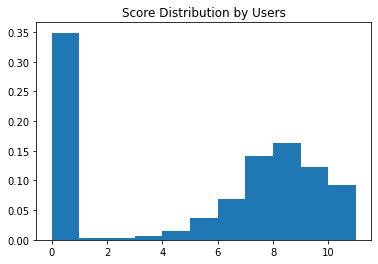

In [32]:
from matplotlib import pyplot
import numpy as np

bins = np.arange(0, 12, 1)
pyplot.hist(final_data["my_score"], density = True, bins = bins)
pyplot.title("Score Distribution by Users")
pyplot.show()

As you can see from the data above, the scores distribution is very disproportionate. Here we will need to classify the results into a specific categorization so it is more clear. Looking at the data, we can use myanimelist's categorization

* 10 - Masterpiece 
* 9 - Excellent
* 8 - Very good
* 7 - Good
* Below or 6 - Fine or average

Also, zeros are likely miscategorizations, since in my anime list 0s cannot be placed as a score. Therefore zeros will be removed from this data

In [33]:
tomodel = final_data[final_data["my_score"] > 0]

In [34]:
def categorize_score(score):
    if score == 10:
        return "Masterpiece"
    elif score == 9:
        return "Excellent"
    elif score == 8:
        return "Very Good"
    elif score == 7:
        return "Good"
    else:
        return "Fine"

In [35]:
tomodel["y_model"] = tomodel["my_score"].apply(lambda d: categorize_score(d))

C:\Users\duart\AppData\Local\conda\conda\envs\testEnv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
tograph = tomodel[["y_model", "my_score"]].groupby(by = ["y_model"]).count().reset_index()

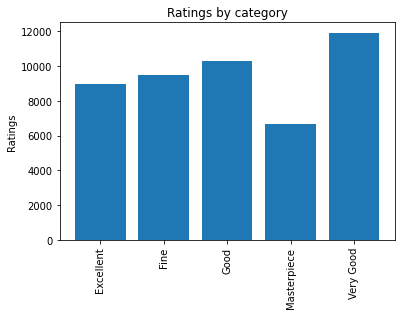

In [37]:
pyplot.bar(x = tograph["y_model"], height = tograph["my_score"])
pyplot.title(f"Ratings by category")
pyplot.ylabel(f"Ratings")
pyplot.xticks(rotation = "vertical")
pyplot.show()

Now the ratings seem levelled, therefore we can use this variable for the model

In [38]:
toanalysis = tomodel[["scored_by", "rank", "popularity", "members", "favorites", "mins", "Shounen", "Shoujo", "Seinen", "Ecchi", "Mecha",\
                      "Supernatural", "SliceofLife", "Action", "Adventure", "Comedy", "Drama", "Magic", "Romance", "Thriller", "Horror", "Fantasy", "y_model"]].groupby(by = ["y_model"]).mean()

In [39]:
toanalysis.sort_values(by = "scored_by", ascending = False)

,scored_by,rank,popularity,members,favorites,mins,Shounen,Shoujo,Seinen,Ecchi,...,SliceofLife,Action,Adventure,Comedy,Drama,Magic,Romance,Thriller,Horror,Fantasy
y_model,,,,,,,,,,,,,,,,,,,,,
Masterpiece,131439.812155,809.852023,950.005226,212031.480514,3904.362550,96.637211,0.204420,0.037032,0.035837,0.007317,...,0.066149,0.409586,0.402718,0.281917,0.455428,0.071375,0.269524,0.080334,0.040765,0.319247
Excellent,106433.785220,941.778745,1074.039183,174521.217013,2662.792588,92.688107,0.212101,0.036727,0.047444,0.007926,...,0.069324,0.451217,0.385242,0.279973,0.436370,0.078142,0.250502,0.091873,0.049341,0.322952
Very Good,80992.534295,1239.138437,1320.608670,134456.468305,1604.688412,87.382401,0.251970,0.033708,0.050394,0.006037,...,0.066326,0.477696,0.398793,0.317374,0.394600,0.084437,0.218430,0.077897,0.046118,0.343787
Good,60469.494472,1798.568755,1693.891389,101113.881594,929.696664,82.355901,0.311870,0.040050,0.041214,0.009407,...,0.049748,0.506885,0.444143,0.374612,0.365012,0.084562,0.194337,0.056633,0.045578,0.384503
Fine,44329.649019,3045.093757,2618.381671,74200.380089,614.780532,72.699594,0.303312,0.034486,0.028580,0.007066,...,0.042080,0.472369,0.443472,0.372073,0.314491,0.071504,0.142586,0.038072,0.052837,0.391057


# Model

In [40]:
final_model = tomodel.drop(["username", "anime_id", "my_watched_episodes", "my_score", "score"], axis = 1)

In [41]:
X = final_model.iloc[:,:-1]
y = final_model["y_model"].values

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [43]:
dummies = pd.get_dummies(final_model[["rating", "source", "gender"]])

In [44]:
X = X.merge(dummies, how = "left", left_index = True, right_index = True).drop(["gender", "source", "rating"], axis = 1)

In [45]:
X_one = X.values

In [46]:
rf = RandomForestClassifier()
param = {'n_estimators': [10, 50, 100, 150, 300],
        'max_depth': [3, 5, 10, 15, 20, None]}

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)
gs_fit = gs.fit(X_one, y)
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,34.381150,9.358585,1.732935,1.357212,10,150,"{'max_depth': 10, 'n_estimators': 150}",0.407916,0.382797,0.384908,0.387335,0.386174,0.389826,0.009169,1
11,10.453162,1.592206,0.298635,0.052251,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.415515,0.381847,0.386807,0.383113,0.381741,0.389805,0.012985,2
14,67.742983,7.421120,1.641335,0.252565,10,300,"{'max_depth': 10, 'n_estimators': 300}",0.404538,0.381953,0.387124,0.385541,0.385541,0.388939,0.007982,3
12,21.551152,3.831313,0.509900,0.117542,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.401478,0.382586,0.383008,0.386491,0.380792,0.386871,0.007533,4
19,74.702319,9.318201,3.462415,1.804298,15,300,"{'max_depth': 15, 'n_estimators': 300}",0.406755,0.380264,0.378470,0.378997,0.387652,0.386427,0.010688,5


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_one,y, test_size=0.2, random_state=7)

num_trees = 100
num_features = 5

model = RandomForestClassifier(n_estimators = num_trees, max_features = num_features, random_state = 7)
model.fit(X_train,y_train)

for name, importance in zip(X.columns, model.feature_importances_):
    print(f'{name:15s}  {importance:.4f}')

import seaborn as sns
sns.barplot(x = X.columns, y = model.feature_importances_)

In [ ]:
# model.score(X_test, y_test)

In [ ]:
y_test

In [ ]:
# predictions = []

# for array in X_test:
#     prediction = model.predict([array])
#     predictions.append(prediction)

In [ ]:
# predictions_df = pd.DataFrame(X_test)
# predictions_df["y_values"] = y_test
# predictions_df["predictions"] = predictions

In [ ]:
# predictions_df["predictions"] = predictions_df["predictions"].apply(lambda d: "".join(d))

In [ ]:
# predictions_df["accurate"] = predictions_df["y_values"].values == predictions_df["predictions"].values
# predictions_df["innacurate"] = predictions_df["y_values"].values != predictions_df["predictions"].values

In [ ]:
# predictions_df[["y_values", "predictions", "accurate", "innacurate"]].groupby(by = ["y_values", "predictions"]).agg({"y_values": "count", "accurate": "sum", "innacurate": "sum"})

There is hope for our model! The wrong predictions its making are not way off base, it is close to the base value. So if a series is excellent, on most cases its failing to predict it right, but its predicting it as very good, which is a category from a conceptual standpoint, which is close to excellent.

This model is screaming for more features so we can predict better 

# Changes to be made

* Clusterize users by watching behavior
* Scored_by, filter by animes greater than 100
* Fix dummies for the model
* Start date and finish date